In [14]:
# Run this cell for autoreload of modules
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from breastcatt.fvit import multimodal_vit_small_patch16

In [18]:
model = multimodal_vit_small_patch16(num_classes=1, use_cross_attn=True, use_segmentation=True)
print(model)

MultiModalVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (language_model): LanguageModel(
    (model_lm): MegatronBertModel(
      (embeddings): MegatronBertEmbeddings(
        (word_embeddings): Embedding(50176, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MegatronBertEncoder(
        (layer): ModuleList(
          (0-23): 24 x MegatronBertLayer(
            (attention): MegatronBertAttention(
              (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (self): MegatronBertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): L

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                                 Param #
MultiModalVisionTransformer                                            76,032
├─PatchEmbed: 1-1                                                      --
│    └─Conv2d: 2-1                                                     98,688
│    └─Identity: 2-2                                                   --
├─Dropout: 1-2                                                         --
├─LanguageModel: 1-3                                                   --
│    └─MegatronBertModel: 2-3                                          --
│    │    └─MegatronBertEmbeddings: 3-1                                (51,906,560)
│    │    └─MegatronBertEncoder: 3-2                                   (302,311,424)
│    │    └─MegatronBertPooler: 3-3                                    (1,049,600)
│    └─Sequential: 2-4                                                 --
│    │    └─Linear: 3-4                                              

In [4]:
from torchvision import transforms

data_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

In [19]:
from torchvision.transforms import Compose, ToTensor, Lambda, RandomResizedCrop, RandomHorizontalFlip

# Min-max normalization to [0, 1] for floating-point TIFFs
min_max_norm = Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))

train_transforms = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    min_max_norm,
])

In [8]:
from datasets import load_dataset

dataset = load_dataset("SemilleroCV/DMR-IR")


In [11]:
sample = dataset['test'][30]
txt = [sample['text']]
print(txt)

['Patient is 72 years old of black race. Has eating habits low in fat. Complaints reported were no. Additionally, patient reported no. No information provided for radiotherapy, use of hormone replacement. Regarding the protocol, a body temperature of 36.90 degrees Celsius, alcohol consumption was no, coffee drinking was no, smoking was no, physical exercise was no.']


In [21]:
import numpy as np
from PIL import Image
import torch

img = sample['image']
img = np.array(img, dtype=np.float32)
txt = [sample['text']]
label = torch.from_numpy(np.array(sample['label'])).unsqueeze(0).float()

# MAX_TEMPERATURE = 36.44
# img = img / MAX_TEMPERATURE #normalizar
matrix = Image.fromarray(img) # np a pil image
matrix = train_transforms(matrix) # trasnformaciones
matrix  = matrix.unsqueeze(0)
print(matrix.shape) # (1, 1, 224, 224)

torch.Size([1, 1, 224, 224])


In [22]:
print(matrix)

tensor([[[[0.3129, 0.3143, 0.3233,  ..., 0.2906, 0.2851, 0.2816],
          [0.3191, 0.3199, 0.3257,  ..., 0.2888, 0.2859, 0.2878],
          [0.3194, 0.3168, 0.3196,  ..., 0.2918, 0.2882, 0.2857],
          ...,
          [0.3382, 0.3409, 0.3472,  ..., 0.7986, 0.7929, 0.7889],
          [0.3309, 0.3430, 0.3457,  ..., 0.7912, 0.7926, 0.7803],
          [0.3394, 0.3380, 0.3466,  ..., 0.7886, 0.7766, 0.7717]]]])


In [23]:
output = model(matrix, texts=txt, labels=label)
print(output)

ModelOutput(logits=tensor([[0.8415]], grad_fn=<AddmmBackward0>), loss=tensor(1.1999, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))


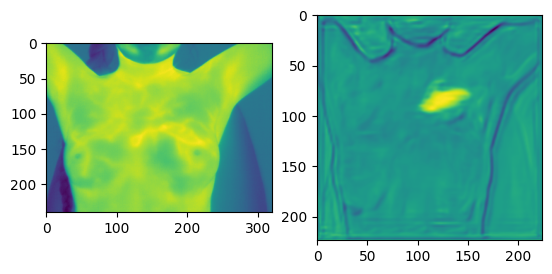

In [ ]:
# DO NOT RUN THIS CELL

# Here I am looking at what results from multiplying point to point the output
# of the segmenting model (logits) with the original image.

# I decided (have to test it) to use the logits instead of the binary mask
# because when the segmentation is bad, the whole image is killed.

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(output.squeeze().detach().numpy())
plt.show()